# Using Clipped PPO for Automated Model Compression


Continuing on the work of [AMC](https://arxiv.org/abs/1802.03494) we replace DDPG with Clipped PPO.

Results are interesting and encouraging as there is learning.  However, this is less sample-efficient compared to DDPG, and therefore takes longer.

We search for a 50%-MACs-constrained (FLOPs-constrained) Plain20.  From Greedy Search algorithm we know that there exists a 50%-MACs-constrained Plain20 that can provide Top1=90%.  The current fine-tuned Plain20 model from our PPO experiments has a Top1=89%.

## Experiment setup


### Clipped PPO configuration

### Distiller Clipped PPO AMC experiments


## Notebook code

Skip this part - it is necessary only for creating the diagrams.  You may also toggle the code-view button.

In [ ]:
from IPython.display import HTML
HTML('<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off code view"></form>')

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib 
import csv
from matplotlib.ticker import FuncFormatter
import ipywidgets as widgets
from ipywidgets import interactive, interact, Layout
import matplotlib.pylab as pylab
import matplotlib.animation as animation
from matplotlib import animation, rc



#plt.style.use('seaborn') # pretty matplotlib plots

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 7),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'xx-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)


def to_percent(y, position):
    # Ignore the passed in position. This has the effect of scaling the default
    # tick locations.
    if y < 1:
        y = 100 * y
    s = "{:.1f}".format(y)

    # The percent symbol needs escaping in latex
    if matplotlib.rcParams['text.usetex'] is True:
        return s + r'$\%$'
    else:
        return s + '%'
    
# Widen the cells to get entire rows in the screen.
from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:100% !important; }</style>"))


def plot_layer_densities(df, idx, action_type='action_history', ax=None, color=None):
    if ax is None:
        plt.figure()
        ax = plt
    
    record = df.iloc[idx]
    layer_sparsities = record[action_type]
    layer_sparsities = layer_sparsities[1:-1].split(",")
    layer_densities = [1.- float(sparsity) for sparsity in layer_sparsities]
    ax.bar(range(len(layer_densities)), layer_densities, color=color)
    ax.set_title("Ep:{} - Top1:{:.1f}%\nMACs:{:.1f}%".format(record['episode'], 
                                                             record['top1'], 
                                                             record['normalized_macs']))
    
    
def smooth(data, win_size):
    if not win_size:
        return data                          # <======= THIS IS A FiX
    win_size = max(0, win_size)
    return [np.mean(data[max(0, i-win_size):i]) for i in range(len(data))]


def plot_performance(alpha, window_size, top1, macs, params, reward, start=0, end=-1):
    plot_kwargs = {"figsize":(15,7), "lw": 1, "alpha": alpha, "title": "Performance Data"}
    smooth_kwargs = {"lw": 2 if window_size > 0 else 1, "legend": True}
    if macs:
        ax = df['normalized_macs'][start:end].plot(**plot_kwargs, color="r")
        ax.set(xlabel="Episode", ylabel="(%)")
        #ax.set_ylim([0,100])
        df['smooth_normalized_macs'] = smooth(df['normalized_macs'], window_size)
        df['smooth_normalized_macs'][start:end].plot(**smooth_kwargs, color="r")
    if top1:
        ax = df['top1'][start:end].plot(**plot_kwargs, color="b", grid=True)
        ax.set(xlabel="Episode", ylabel="(%)")
        df['smooth_top1'] = smooth(df['top1'], window_size)
        df['smooth_top1'][start:end].plot(**smooth_kwargs, color="b")
    if params:
        ax = df['normalized_nnz'][start:end].plot(**plot_kwargs, color="black")
        ax.set(xlabel="Episode", ylabel="(%)")
        df['smooth_normalized_nnz'] = smooth(df['normalized_nnz'], window_size)
        df['smooth_normalized_nnz'][start:end].plot(**smooth_kwargs, color="black")        
    if reward:
        ax = df['reward'][start:end].plot(**plot_kwargs, secondary_y=True, color="g")
        ax.set(xlabel="Episode", ylabel="reward")
        df['smooth_reward'] = smooth(df['reward'], window_size)
        df['smooth_reward'][start:end].plot(**smooth_kwargs, secondary_y=True, color="g")    
    #ax.set_ylim([0,100])
    ax.grid(True, which='minor', axis='x', alpha=0.3)
        
        
def plot_2d_embeddings(top1, normalized_macs):
    plt.figure(figsize=(15,7))        
    plt.title('Projection of Discovered Networks ({})'.format(len(top1)))     
    plt.xlabel('Normalized MACs')
    plt.ylabel('Top1 Accuracy')

    # Create the formatter using the function to_percent. This multiplies all the
    # default labels by 100, making them all percentages
    formatter = FuncFormatter(to_percent)

    # Set the formatter
    plt.gca().yaxis.set_major_formatter(formatter)
    plt.gca().xaxis.set_major_formatter(formatter)

    # Use color gradients to show the "age" of the network:
    # Lighter networks were discovered earlier than darker ones.
    color_grad = [str(1-i/len(top1)) for i in range(len(top1))]
    plt.scatter(normalized_macs, top1, color=color_grad, s=80, edgecolors='gray');

    
INTERVAL = 30 # Animation speed
WINDOW = 20

font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'alpha': 0.50,
        'size': 32,
        }

# Based on these two helpful example code: 
# https://stackoverflow.com/questions/9401658/how-to-animate-a-scatter-plot
# http://louistiao.me/posts/notebooks/embedding-matplotlib-animations-in-jupyter-notebooks/.
# Specifically, the use of IPython.display is missing from the first example, but most of the animation code
# leverages code from there.
class AnimatedScatter(object):
    """An animated scatter plot using matplotlib.animations.FuncAnimation."""
    def __init__(self, xdata, ydata):
        assert len(xdata) == len(ydata)
        self.numpoints = len(xdata)
        self.xdata = xdata
        self.ydata = ydata
        self.stream = self.data_stream()

        # Setup the figure and axes...
        self.fig, self.ax = plt.subplots(figsize=(15,7))
        # Then setup FuncAnimation.
        self.ani = animation.FuncAnimation(self.fig, self.update, interval=INTERVAL,
                                           frames=self.numpoints-2, 
                                           init_func=self.setup_plot, blit=True)

    def setup_plot(self):
        """Initialize drawing of the scatter plot."""
        x, y, s, c = next(self.stream)
        #self.annot = self.ax.annotate("txt", (10, 10))
        self.scat = self.ax.scatter(x, y, c=c, s=s, animated=False)
        self.scat.set_edgecolors('gray')
        self.scat.set_cmap('gray')
        self.width = max(self.xdata) - min(self.xdata) + 4
        self.height = max(self.ydata) - min(self.ydata) + 4
        self.ax.axis([min(self.xdata)-2, max(self.xdata)+2, 
                      min(self.ydata)-2, max(self.ydata)+2])
        
        self.annot = self.ax.text(min(self.xdata) + self.width/2, 
                     min(self.xdata) + self.height/2, 
                     "", fontdict=font)
        # For FuncAnimation's sake, we need to return the artist we'll be using
        # Note that it expects a sequence of artists, thus the trailing comma.
        return self.scat, 

    def data_stream(self):
        numpoints = 0#len(self.xdata)
        colors = []
        xxx = 0
        while True:
            numpoints += 1
            win_len = min(WINDOW, numpoints)
            data = np.ndarray((4, win_len))
            start = max(0,numpoints-WINDOW-1)
            data[0, :] = self.xdata[start:start+win_len]
            data[1, :] = self.ydata[start:start+win_len]
            data[2, :] = [70] * win_len  # point size
            #data[3, :] = [np.random.random() for p in range(numpoints)]  # color
            # The color of the points is a gradient with larger values for "younger" points.
            # At each new frame we show one more point, and "age" each existing point by incrementaly  
            # reducing its color gradient.
            data[3, :] = [(1-i/(win_len+1)) for i in range(win_len)] 
            yield data

    def update(self, i):      
        """Update the scatter plot."""
        data = next(self.stream)
        self.annot.set_text(i)
        i = i % len(data)
            
        # Set x and y data
        xy = [(data[0,i], data[1,i]) for i in range(len(data[0,:]))]
        self.scat.set_offsets(xy)
        
        # Set colors
        self.scat.set_array(data[3])
        
        # We need to return the updated artist for FuncAnimation to draw..
        # Note that it expects a sequence of artists, thus the trailing comma.
        return self.scat, self.annot

    def show(self):
        plt.show()


## Results

Below I present the results of a single execution.  There is a substantial variance between the experiment executions, but most conclude similarly to this experiment.

### Read the results log files

The code below reads the log file of your selected experiment.  To change the path to the file you will need to open the code cell and change its content.

In [1045]:
pd.set_option('display.max_colwidth', 150)
fpath = "../classifier_compression/logs/{}/amc.csv"

fname = "sample_logs/clipped_ppo/macs_constrained_clipped-ppo.amc.csv"
fname = "../classifier_compression/logs_stash/resnet56-amc___2019.02.01-053412/amc.csv"
#fname = "../classifier_compression/logs_stash/plain20-amc-random-2___2019.02.06-063954/amc.csv"
#fname = fpath.format("plain20-amc-ft_freq_1___2019.03.06-141637")
fname = fpath.format("2019.05.02-170638")
fname = fpath.format("2019.05.07-225658") # fm reconstruction
fname = fpath.format("2019.05.12-145714") # random L1- looks optimistic
fname = fpath.format("2019.05.12-173207") 
fname = fpath.format("2019.05.12-225134") # reconstruction w/o FT (89.3)
#  time python3 compress_classifier.py --arch=plain20_cifar ../../../data.cifar --resume=checkpoint.plain20_cifar.pth.tar --lr=0.05 --amc --amc-protocol=mac-constrained --amc-action-range 0.05 0.80 --amc-target-density=0.5 -p=50 --etes=0.3 --gpus=0 --amc-prune-method=stochastic-l1-rank --amc-ft-epochs=1
#  time python3 compress_classifier.py --arch=plain20_cifar ../../../data.cifar --lr=0.1 --vs=0 --num-best-scores=5 -p=50 --epochs=60 --gpu=0 --resume=logs/2019.05.13-134220/BEST_adc_episode_477_checkpoint.pth.tar --compress=../automated_deep_compression/fine_tune.yaml
fname = fpath.format("2019.05.13-134220") # stochastic L1 (ep=0.1) w/ FT
# time python3 compress_classifier.py --arch=plain20_cifar ../../../data.cifar --resume=checkpoint.plain20_cifar.pth.tar --lr=0.05 --amc --amc-protocol=mac-constrained --amc-action-range 0.05 0.80 --amc-target-density=0.5 -p=50 --etes=0.3 --gpus=0 --amc-prune-method=fm-reconstruction --amc-prune-pattern=channels --amc-ft-epochs=0
fname = fpath.format("2019.05.13-193438") # stochastic L1 (ep=0.1) w/o FT
fname = fpath.format("2019.05.22-000039") # mobilenet; biased gaussian distribution
# with action space = {-1, 1}
fname = fpath.format("mobilenet-gauss-shifted-scaled___2019.05.23-031236/") # mobilenet; shifted+scaled gaussian distribution
fname = fpath.format("mobilenet-gauss-shifted-scaled___2019.05.23-235513/") # SH's DDPG - 375 images
fname = fpath.format("mobilenet-gauss-shifted-scaled___2019.05.24-015035/") # SH's DDPG - 3750 images - action 0.05 - 0.8

#fname = fpath.format("mobilenet-gauss-shifted-scaled___2019.05.24-021003/") # mobilenet PPO - newest version (better action distribution)

fname = fpath.format("mobilenet-han-L1___2019.05.25-120749/") # Failure
#fname = fpath.format("mobilenet-ddpg-reconstruction___2019.05.25-155416/") # mobilenet SH's DDPG - my reconstruction
fname = fpath.format("mobilenet-ddpg-reconstruction___2019.05.27-000814") # Good! seed=2018

fname = fpath.format("mobilenet-ddpg-reconstruction___2019.05.27-173606/") #SH DDPG, 

# Examples of "failing" Coach DDPG
#fname = fpath.format("mobilenet-ddpg-reconstruction___2019.05.28-061806/") # Coach DDPG - again (Tab )
#fname = fpath.format("mobilenet-ddpg-reconstruction___2019.05.28-062438/") # Coach DDPG - Single GPU (2)

fname = fpath.format("mobilenet-ddpg-reconstruction___2019.05.28-124524/") # SH DDPG, better division of dataset?

fname = fpath.format("mobilenet-ddpg-reconstruction___2019.05.28-202133/") # 
fname = fpath.format("mobilenet-ddpg-reconstruction___2019.05.28-223402/") # 

fname = fpath.format("mobilenet-coach-ddpg-reconstruction___2019.05.29-135539/") 
# fname = fpath.format("mobilenet-ddpg-reconstruction___2019.05.30-021659/") 
#fname = fpath.format("2019.06.03-015359")  # Plain 20, 5000 calibration, 
fname = fpath.format("mobilenet-ddpg-reconstruction___2019.06.03-123828/") # Running Tab 3 - Coach DDPG - MobileNet

#fname = fpath.format("mobilenet-ddpg-reconstruction___2019.06.03-141214/") # Tab 7 - Coach DDPG - MobileNet
#fname = fpath.format("2019.06.03-154857") # - Sanity test on Plain20
#fname = fpath.format("2019.06.03-163804")

# fname = fpath.format("2019.06.03-213842") # bottom
#fname = fpath.format("2019.06.04-115337") # fixed Coach DDPG


#fname = fpath.format("2019.06.06-130931") # Tab 0 - bottom - Plain20 - Group of 8 channels; 20 sampled points
fname = fpath.format("mobilenet-ddpg-reconstruction___2019.06.09-233457/") # mobilenet ==> Top1: 56.4%
#fname = fpath.format("2019.06.10-005424/") # resnet56; punish_agent  ==> Top1: 90.1%
#     fname = fpath.format("2019.06.10-005041/") # plain20
#fname = fpath.format("2019.06.10-020945") # resnet56; channels; ==> Top1:90.1
#fname = fpath.format("2019.06.10-020027") # plain20 ==> 68.1

#fname = fpath.format("2019.06.10-112343") # plain20 ==> 54.6
fname = fpath.format("mobilenet-ddpg-reconstruction___2019.06.10-104350/") # 
fname = fpath.format("2019.06.11-013033/") # Coach master (tab 7)
#fname = fpath.format("2019.06.11-020319/") #  Coach master - no BN (tab 3)

fname = fpath.format("mobilenet-ddpg-reconstruction___2019.06.11-131708/")  # TD3 - Mobilenet
#fname = "../classifier_compression/latest_log_dir/amc.csv"  # Coach master - no BN + reward baseline (tab 7)
df = pd.read_csv(fname)
#df[600:]|We 

print(len(df))


365


### Plot experiment performance

In [1044]:
plt.figure(figsize=(15,7))
#print(plt.style.available)
#plt.style.use('bmh')

@interact(window_size=(0,50,5), top1=True, macs=True, params=False, reward=True)
def plot_performance_proxy(window_size=10, top1=True, macs=True, params=False, reward=True):
    plot_performance(0.15, window_size, top1, macs, params, reward)

<Figure size 1080x504 with 0 Axes>

interactive(children=(IntSlider(value=10, description='window_size', max=50, step=5), Checkbox(value=True, description='top1'), Checkbox(value=True, description='macs'), Checkbox(value=False, description='params'), Checkbox(value=True, description='reward'), Output()), _dom_classes=('widget-interact',))

### Sample some networks

Let's look at the networks with the best top1 accuracy, and see if they share geometrical attributes.

We sort the discovered networks by their Top1 accuracy and display the density of each layer in the networks.  

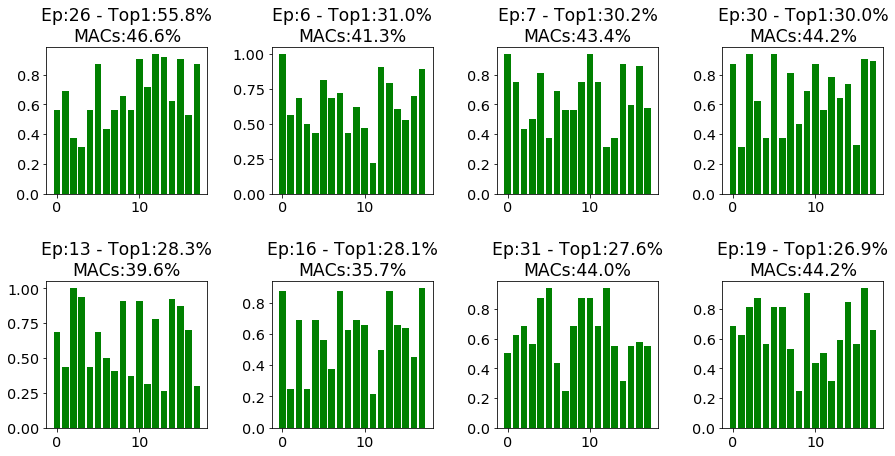

In [958]:
top1_sorted_df = df.sort_values(by=['reward'], ascending=False)
nrows = 2; ncols = 4
f, axarr = plt.subplots(nrows, ncols, figsize=(15,7))
for i in range(0, nrows * ncols):
    plot_layer_densities(top1_sorted_df, i, ax=axarr[i//ncols, i%ncols], color='g')
    # Fine-tune figure; make subplots farther from each other.
    f.subplots_adjust(hspace=0.6, wspace=0.4)

#pd.set_option('display.max_colwidth', -1)
#top1_sorted_df[top1_sorted_df['episode']==2113]
#top1_sorted_df

### Per-layer filter density distribution - top 10% networks

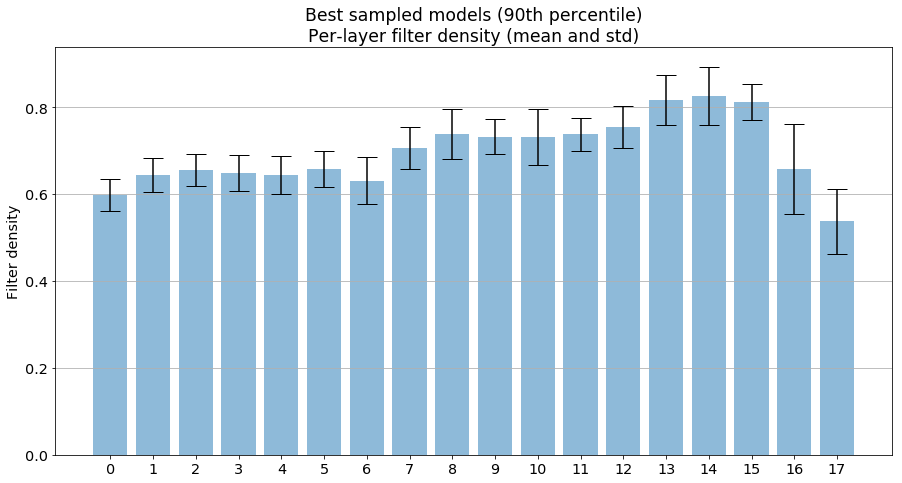

In [897]:
top10pct = top1_sorted_df[:int(len(df.index) * 0.1)]
#top10pct = df[int(len(df.index) * 0.95):]

layer_densities_list = []
for index, row in top10pct.iterrows():
    layer_sparsities = row['action_history']
    layer_sparsities = layer_sparsities[1:-1].split(",")  # convert from string to list
    layer_densities = [1. - float(sparsity) for sparsity in layer_sparsities]
    layer_densities_list.append(layer_densities)

layer_densities = np.array(layer_densities_list)
mean = layer_densities.mean(axis=0)
std = layer_densities.std(axis=0)


# Draw the bar diagram of the layer densities
fig, ax = plt.subplots(figsize=(15,7.5))
ax.set_title("Best sampled models (90th percentile)\nPer-layer filter density (mean and std)")
xpos = [i for i in range(len(mean))]
ax.bar(xpos, mean, yerr=std, capsize=10, alpha=0.5, ecolor='black')
ax.set_ylabel('Filter density')
ax.set_xticks(xpos)
#ax.set_xticklabels(layer_names)
ax.yaxis.grid(True)
#plt.tight_layout()
plt.show()

### Network 2D embeddings

Let's create an embedding of the networks AMC discovers over the course of each experiment session.  Each network is projected onto a 2D plane mapping the Top1 accuracy versus the compute budget, and is represented by a small circle. I used gradient-color-coding to show the relative phase where each network is discovered.  Lighter circles are networks discovered early in the search, darker networks are discovered later.

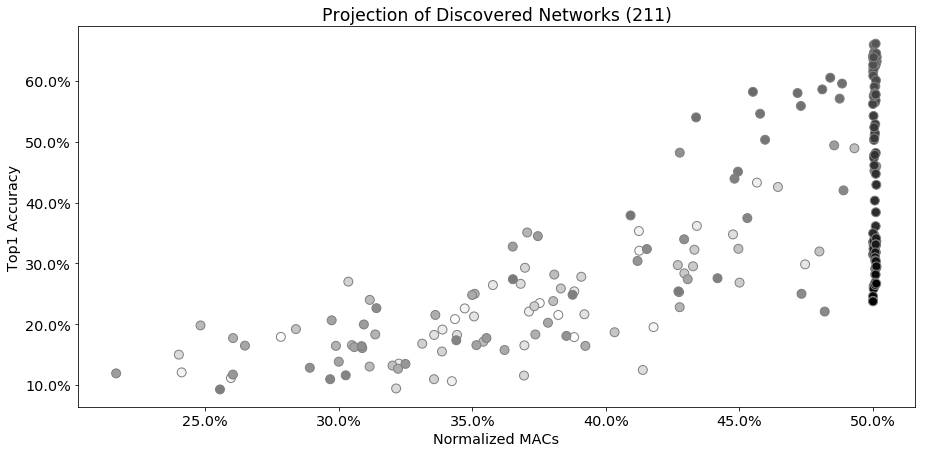

In [898]:
top1 = df['top1']
normalized_macs = df['normalized_macs']
plot_2d_embeddings(top1, normalized_macs)

### Video animation

In [ ]:
a = AnimatedScatter(normalized_macs, top1)
plt.title('Projection of Discovered Networks ({})'.format(len(top1)))  
plt.xlabel('Normalized MACs')
plt.ylabel('Top1 Accuracy')
#a.ani.save('amc_vgg16.mp4', fps=10, dpi=80) #Frame per second controls speed, dpi controls the quality 
rc('animation', html='html5')
a.ani

## Plot a histogram of the actions

We want to look at the distribution of the sampled agent actions (```agent_actions``` below), to make sure they are not skewed or biased.

We also want to compare these actions to the actions the environment actually acts on (these we call ```env_actions``` below).  The natural PPO action-space is (-inf, inf) so the environment needs to scale and shift the agent actions to fit into the "real" action-space.

In [ ]:
def get_all_actions(df, action_type='action_history'):
    actions = []
    for index, record in df.iterrows():
        layer_sparsities = record[action_type]
        layer_sparsities = layer_sparsities[1:-1].split(",")
        layer_sparsities = [float(sparsity) for sparsity in layer_sparsities]
        actions.extend(layer_sparsities)
    return actions

In [ ]:
#fname = "../classifier_compression/logs/{}/amc.csv"
#fname = fname.format("plain20-amc-ft_freq_1___2019.03.06-141111")
#df = pd.read_csv(fname)

agent_actions = get_all_actions(df, action_type='agent_action_history')
env_actions = get_all_actions(df, action_type='action_history')
print(len(agent_actions))

plt.figure(figsize=[15,7.5])
plt.hist(agent_actions, histtype='step', bins=100, label='agent_actions (u={:.2f} std={:.2f})'.format(
                                                                                        np.mean(agent_actions),
                                                                                        np.std(agent_actions)));
plt.hist(env_actions, histtype='step', bins=100, label='env_actions (u={:.2f} std={:.2f})'.format(
                                                                                        np.mean(env_actions),
                                                                                        np.std(env_actions)));

plt.title('Action histogram (actions as seen by the environment)')
plt.legend()
plt.xlabel('Action value')
plt.ylabel('Frequency');